# Insurance Market Customer Segmentation

## Intro

In this analysis, we delve into customer data from a CSV file to conduct exploratory data analysis (EDA), visualize key distributions, and perform customer segmentation. We begin by cleaning the data and addressing missing values through KNN imputation on standardized data. Following data preparation, we apply K-Means clustering to identify distinct customer segments and employ dimensionality reduction for 2D visualization of this different customer classes. To further enhance our understanding, we train an XGBoost classification model to predict customer clusters and evaluate its effectiveness, which can be a valuable tool for future classification tasks, providing reliable predictions of customer segments and supporting the development of targeted marketing strategies.

### What is Market Segmentation?
Market segmentation involves dividing a broad market into subgroups of consumers with shared characteristics, allowing for more targeted and effective marketing strategies.

### Objective
The goal is to develop a customer segmentation strategy that informs recommendations for products such as saving plans, loans, and wealth management, tailored to different customer groups.

### Dataset
The dataset encompasses the usage behavior of approximately 9,000 active credit cardholders over the past six months, featuring 16 numeric and continuous behavioral variables. There is no explicit dependent variable in this dataset, focusing solely on customer attributes.

### [Kaggle link](https://www.kaggle.com/datasets/jillanisofttech/market-segmentation-in-insurance-unsupervised)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

df = pd.read_csv('CustomerData.csv')

## EDA and Visualization

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

We don't care about the customers' ID so we drop it

In [3]:
df.drop(labels=['CUST_ID'], axis=1, inplace=True)

There are missing values in MINIMUM_PAYMENTS. We are going to replace them with a KNN imputer.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# First standardize variables
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Predict missing values
imputer = KNNImputer(n_neighbors=5)
df_scaled_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df.columns)

# Get df on original scale
df = pd.DataFrame(scaler.inverse_transform(df_scaled_imputed), columns=df.columns)

# See info again to check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   float64
 11  PURCHASES_TRX                     8950 non-null   float64
 12  CREDIT

The scaler and imputer turned some integer variables into floating point variables. Now we turn them back into int64.

In [5]:
int_cols = ['CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'TENURE']
df[int_cols] = df[int_cols].astype('int64')

# Now let's see some rows
df.sample(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
8745,1000.814822,0.285714,0.00,0.00,0.0,3465.266978,-5.551115e-17,0.000000,0.000000,0.142857,6,0,6000.0,235.351288,460.696500,0.0,7
6400,1434.793889,1.000000,467.88,467.88,0.0,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0,12,4300.0,2538.815988,2898.375147,0.0,12
7377,659.121167,1.000000,458.50,0.00,458.5,0.000000,9.166670e-01,0.000000,0.916667,0.000000,0,11,1500.0,65.156724,2883.926424,0.0,12
340,907.982017,1.000000,216.94,216.94,0.0,1011.997944,1.666670e-01,0.166667,0.000000,0.166667,5,3,3200.0,222.023160,300.210049,0.0,12
4806,34.706824,0.181818,242.90,242.90,0.0,0.000000,8.333300e-02,0.083333,0.000000,0.000000,0,2,1500.0,85.290895,174.958496,0.0,12


### Some distribution visualization

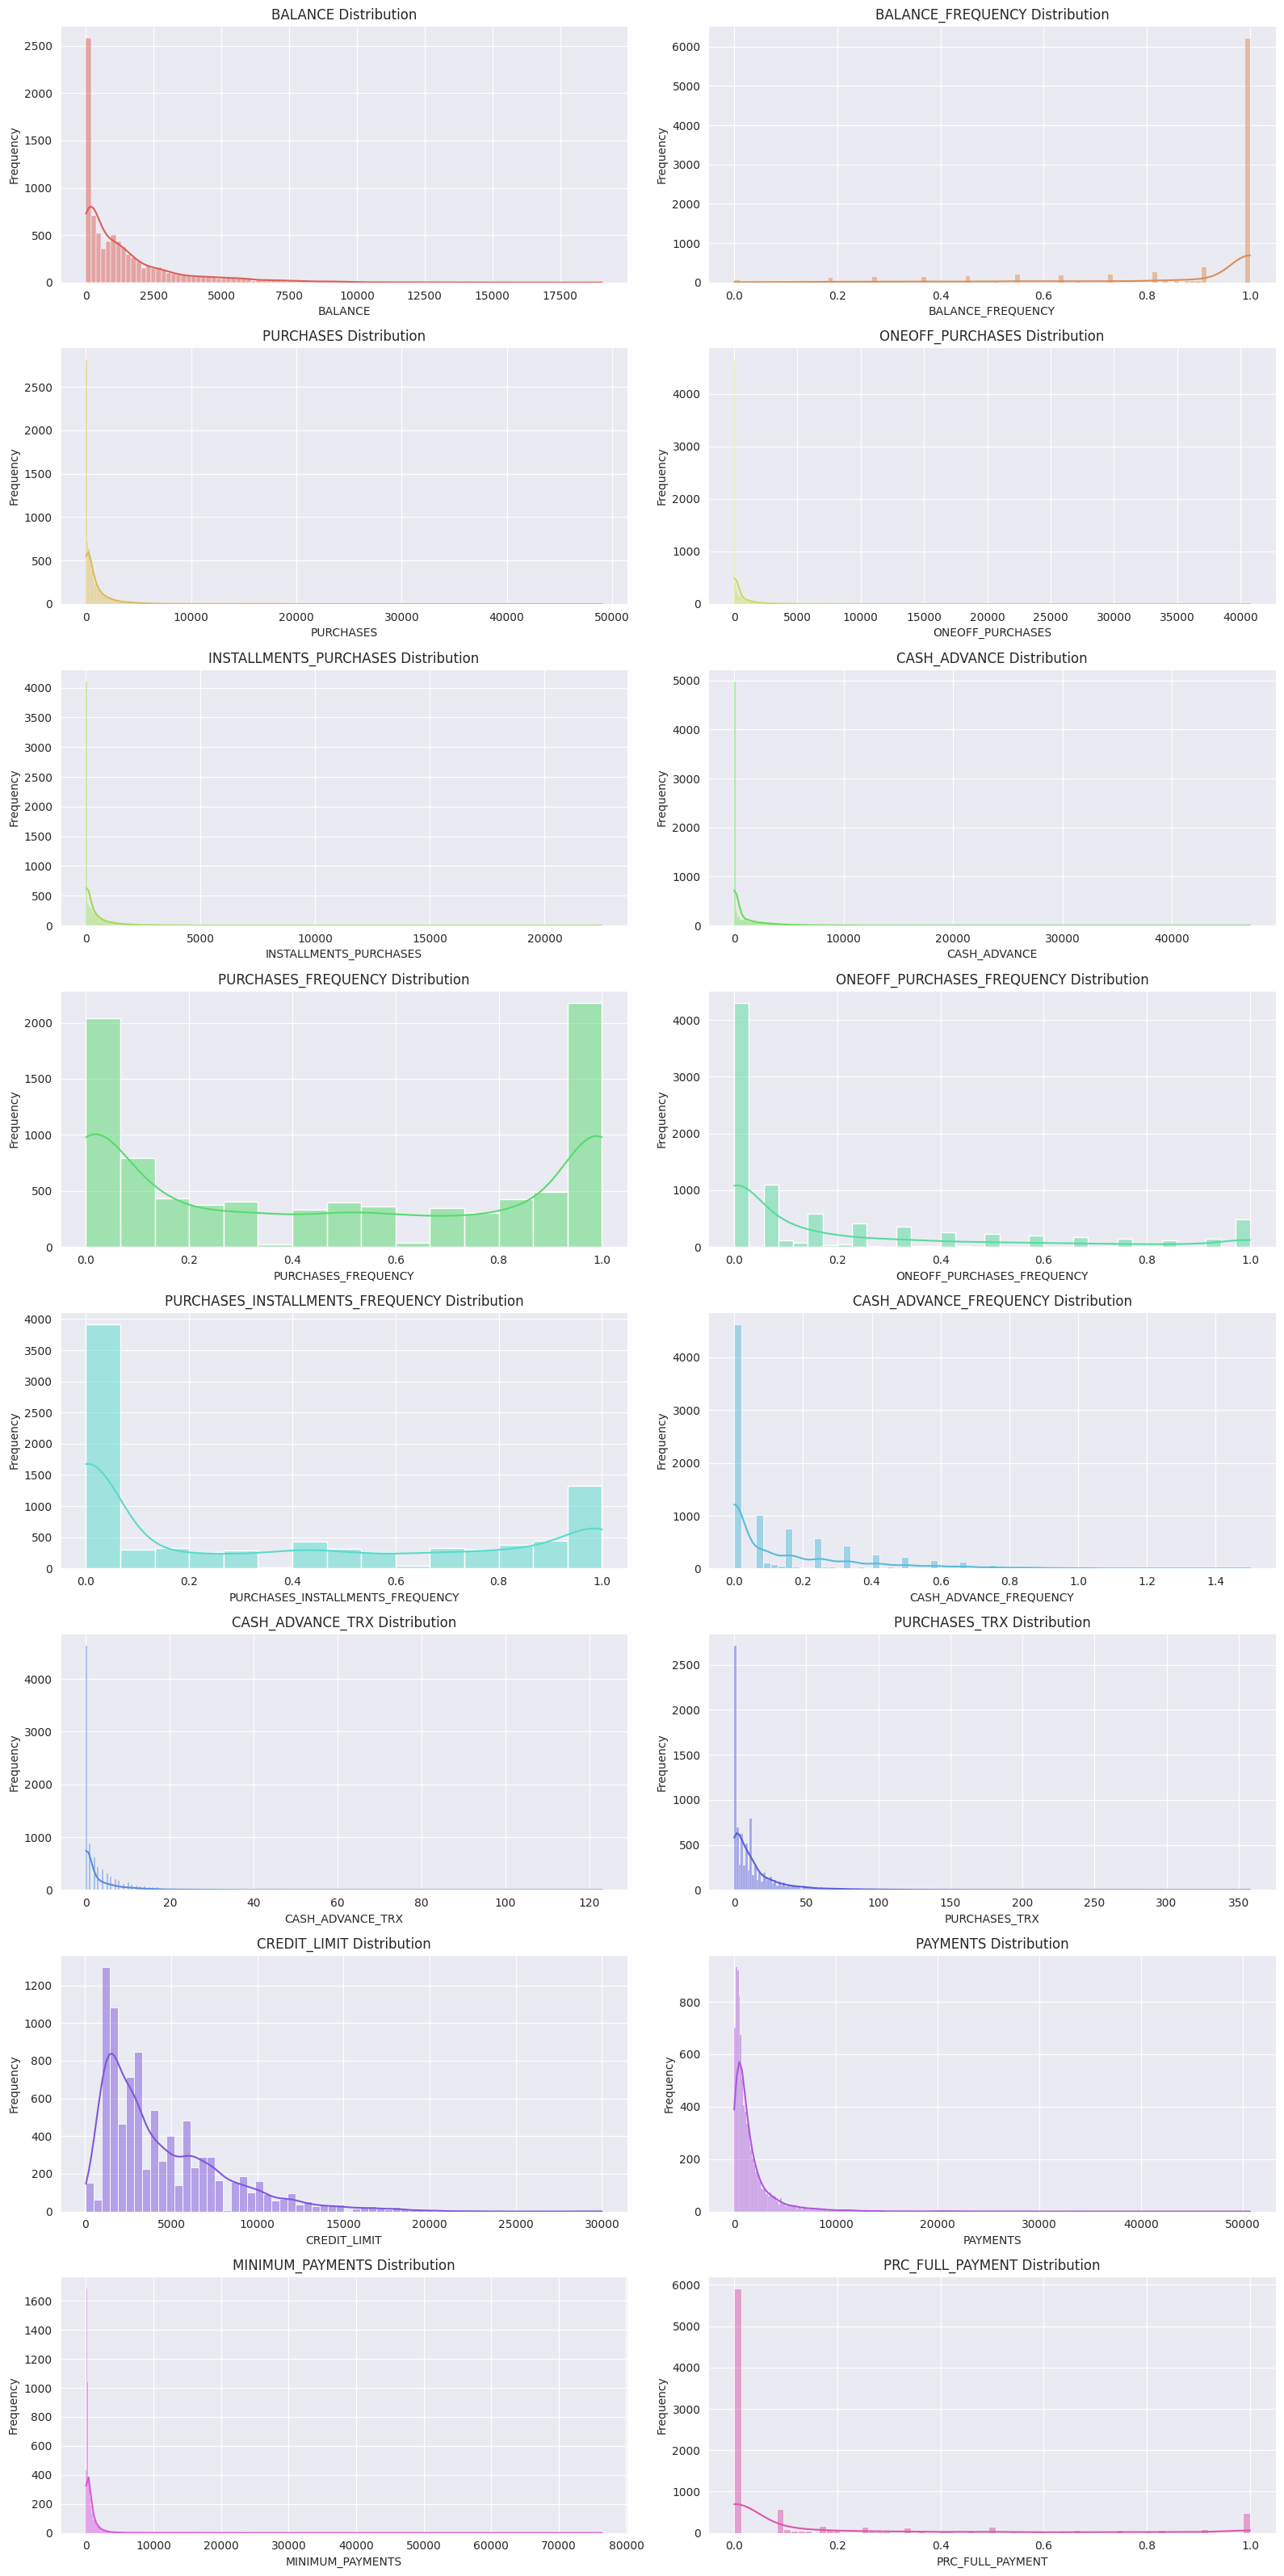

In [6]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(2*8, 8*4))
axes = axes.flatten()

columns = df.columns.tolist()
colors = sns.color_palette('hls', len(columns))

for i in range(16):
    sns.histplot(data=df[columns[i]], kde=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f'{columns[i]} Distribution', fontsize=12)
    axes[i].set_xlabel(f'{columns[i]}', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
   
plt.tight_layout()

Scatterplot for each pair of variables would be useful, but there are too many variables to create an n×n plot. Here I plot some of the most interesting ones.

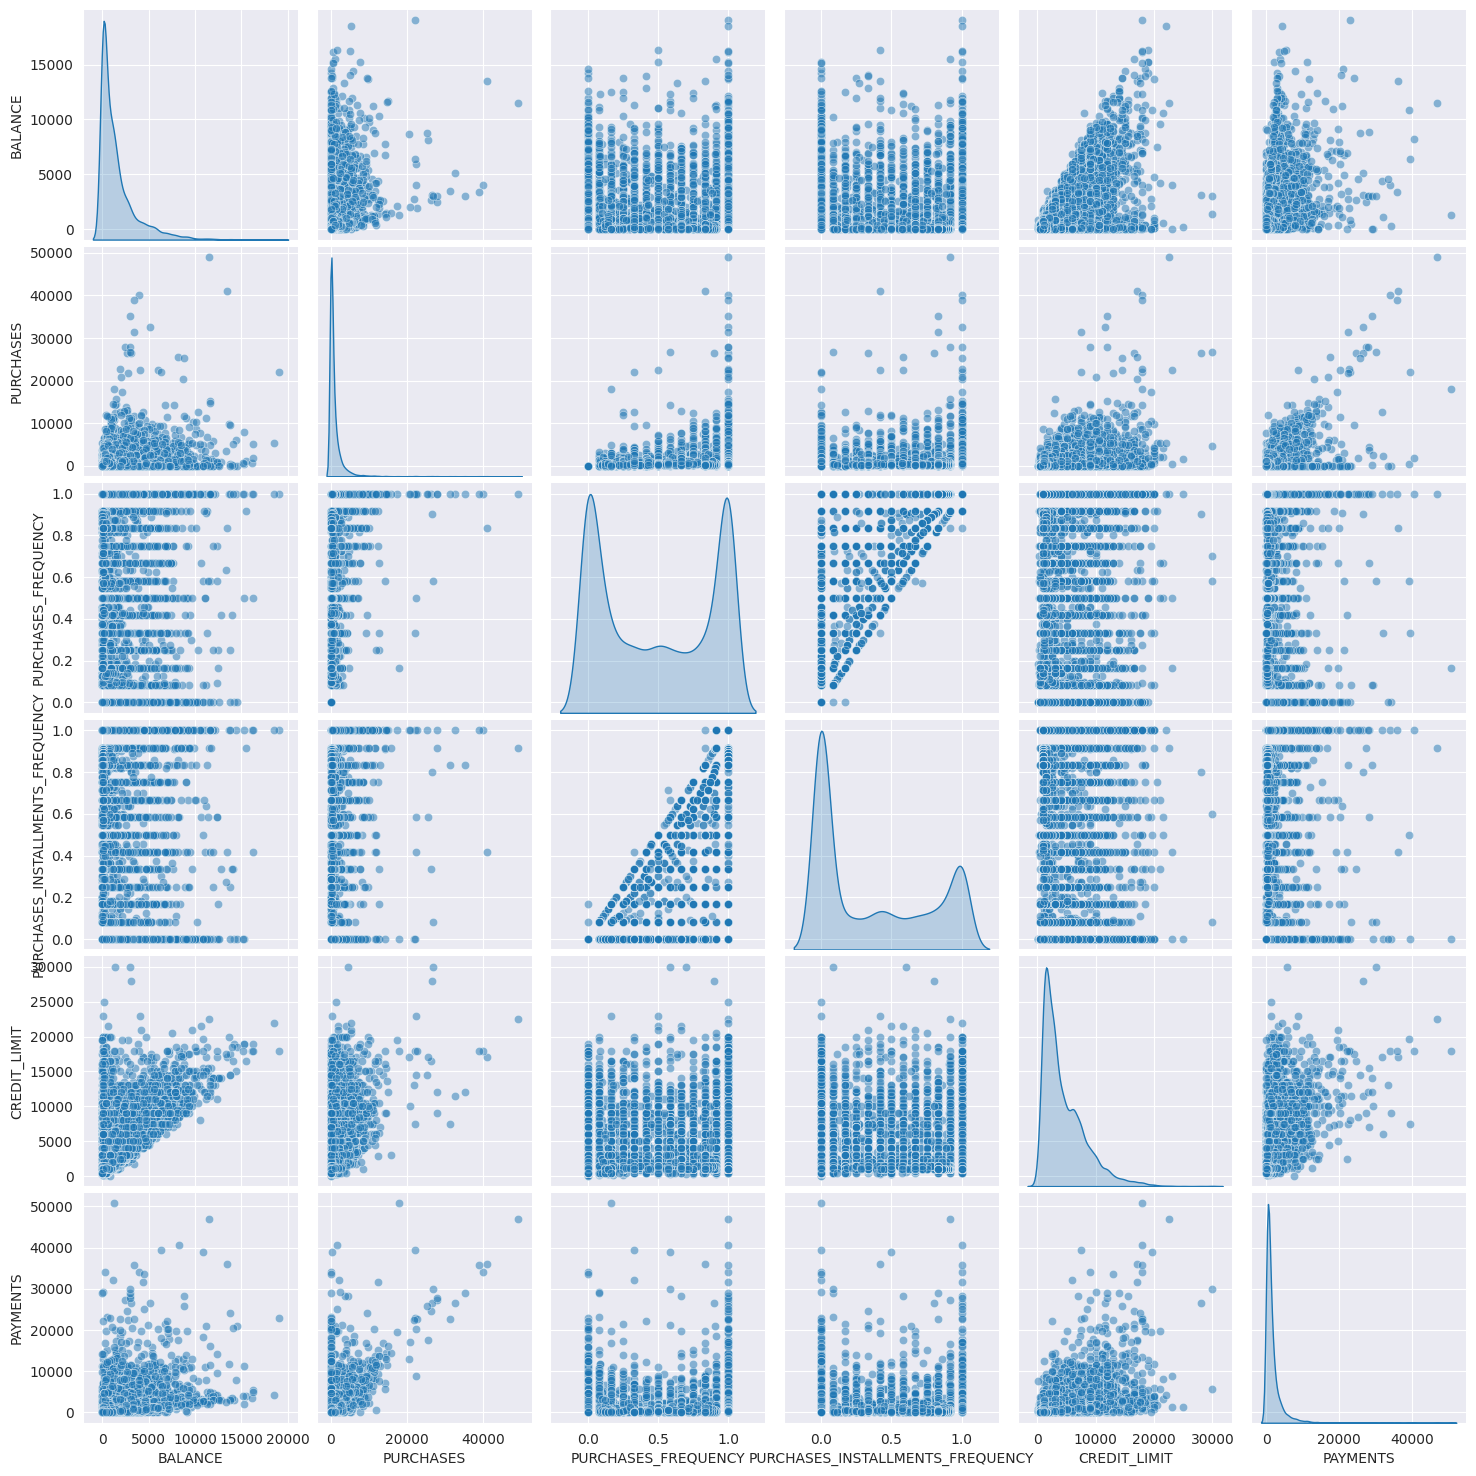

In [36]:
some_cols = ['BALANCE', 'PURCHASES', 'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS']

sns.pairplot(df[some_cols], diag_kind='kde', kind='scatter', height=2.5, aspect=1,
             plot_kws={'alpha':0.5})

Now let's see the correlation matrix:

<Axes: >

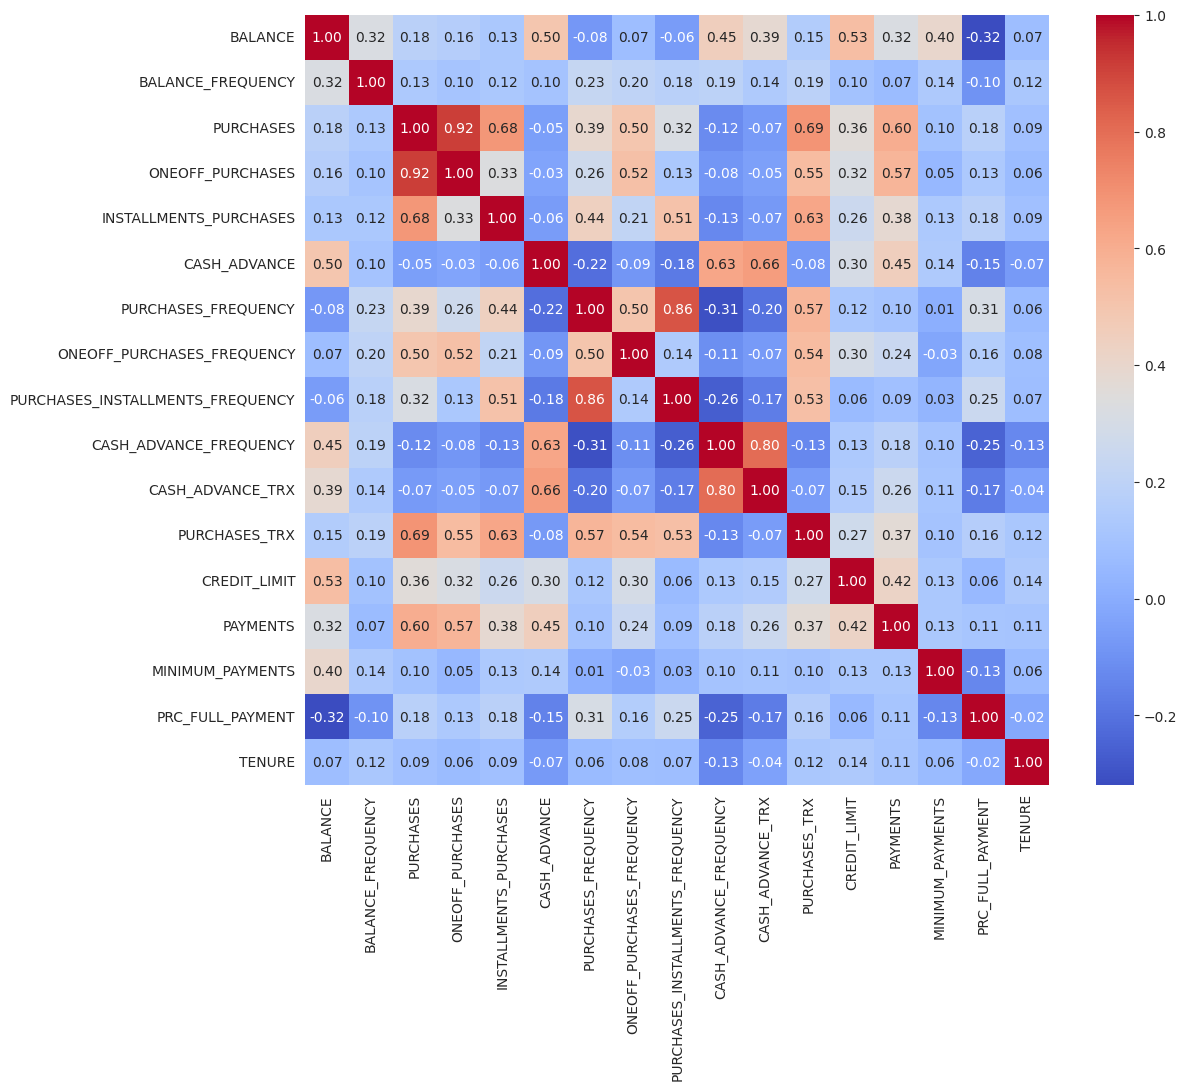

In [33]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm',)

## Customers clustering

### Dimensionality reduction for later visualization

In [8]:
from sklearn.decomposition import PCA

# We are gonna use the standard scaled df from before
pca = PCA(n_components=2) # 2 dimensions for plotting

components = pca.fit_transform(df_scaled_imputed)
df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])

df_pca.sample(5)

,PC1,PC2
7644,0.474872,-1.924741
2497,-0.202043,-0.565712
7961,-0.520943,-2.318110
3118,4.051899,3.662113
5694,3.034151,-1.670874


### Elbow Method

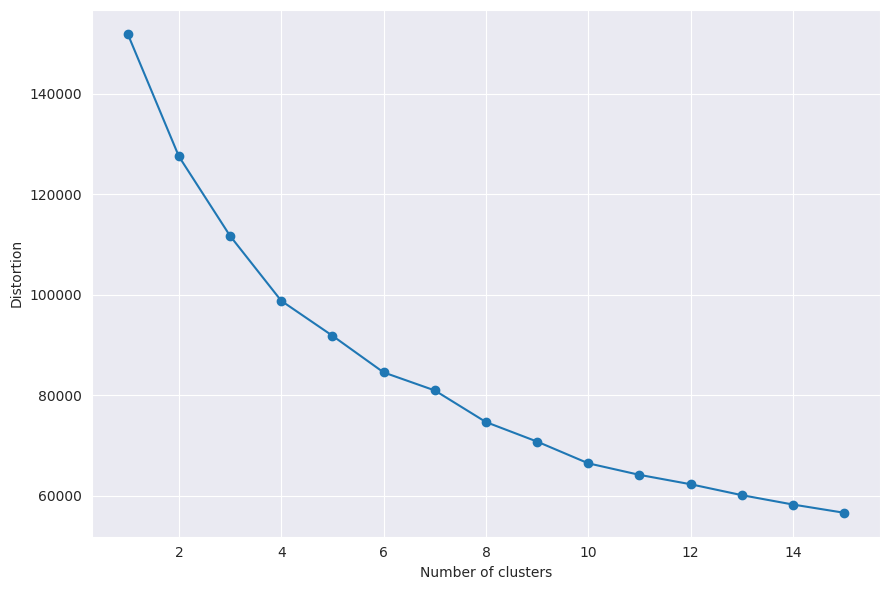

In [9]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1,16):
    km = KMeans(n_clusters=i,
                init='k-means++',
                random_state=131002)
    km.fit(df_scaled_imputed)
    distortions.append(km.inertia_)

plt.figure(figsize=(9,6))
plt.plot(range(1,16), distortions, marker='o')
plt.ylabel('Distortion')
plt.xlabel('Number of clusters')
plt.tight_layout()

4 seems to be an elbow and an appropriate number of clusters.

### K-Means model building, with k=4


In [10]:
kmeans = KMeans(n_clusters=4,
                init='k-means++',
                random_state=13)

kmeans.fit(df_scaled_imputed)

KMeans(n_clusters=4, random_state=13)

### Silhouette plot

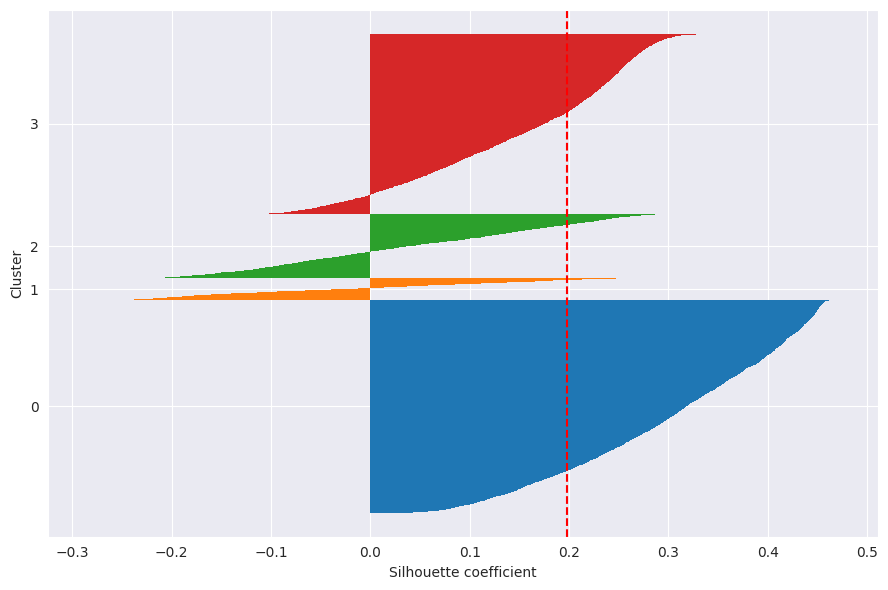

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate silhouette values for each sample
silhouette_vals = silhouette_samples(df_scaled_imputed, kmeans.labels_)
silhouette_mean = silhouette_score(df_scaled_imputed, kmeans.labels_)

cluster_labels = np.unique(kmeans.labels_)
n_clusters = cluster_labels.shape[0]

colors = plt.get_cmap("tab10").colors

# Initialize variables for plotting
y_ax_lower, y_ax_upper = 0, 0
yticks = []

plt.figure(figsize=(9,6))
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[kmeans.labels_ == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=colors[i])
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_mean, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()

Clusters 0 and 3 have a high positive silhouette width, indicating good clustering classification. Cluster 1 and 2 have both positive and negative values, suggesting some overlap or misclassification.

### Visualizing clustered data

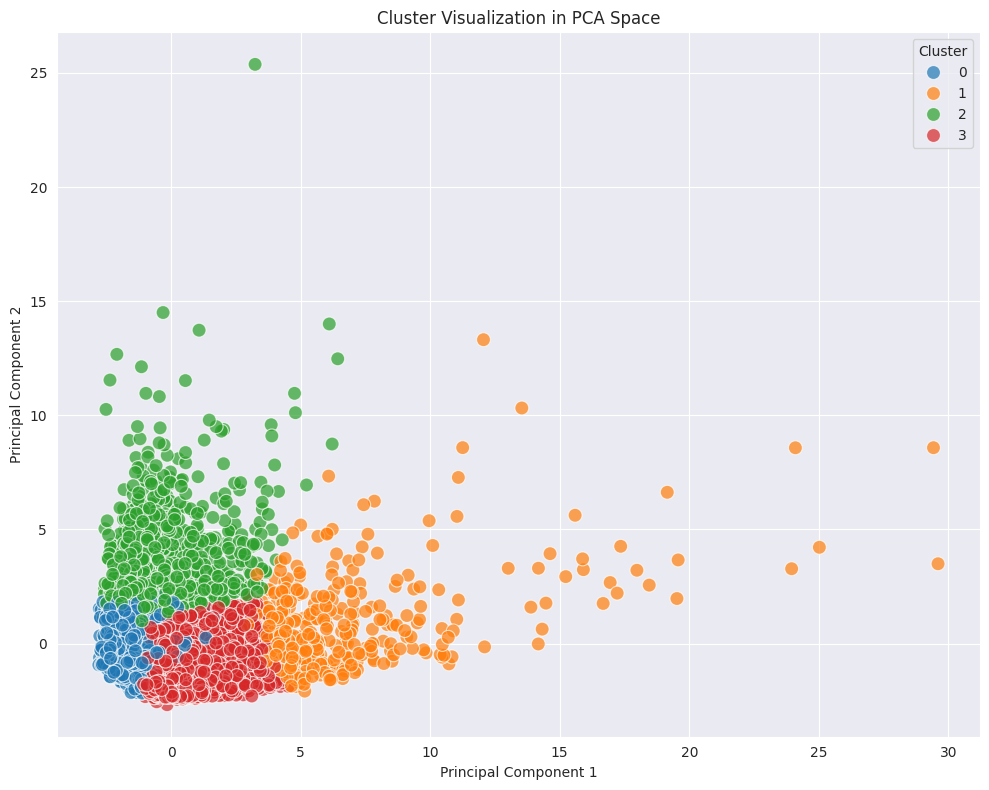

In [49]:
df_pca['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='tab10', s=100, alpha=0.7)

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization in PCA Space')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()

The orange and green clusters appear to be the most sparse, resulting in a higher number of distant points and potential misclassifications. This is evident from the silhouette plot, which shows lower silhouette scores for these clusters.

### Cluster centers of each variable

In [14]:
cluster_centers = kmeans.cluster_centers_

# The cluster centers are standardized so we scale it back to te original scale
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(cluster_centers, columns=df.columns.tolist())
cluster_centers

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1009.631532,0.789520,270.339023,210.060428,60.545953,591.880650,0.170591,0.086369,0.080931,0.114254,2.113322,2.909846,3274.851003,971.057946,548.883046,0.078008,11.448250
1,3551.153761,0.986879,7681.620098,5095.878826,2587.208264,653.638891,0.946418,0.739031,0.788060,0.071290,2.085575,89.359413,9696.943765,7288.739497,1981.855301,0.286707,11.951100
2,4586.930606,0.968357,499.232921,318.702631,180.614664,4509.716842,0.286336,0.138196,0.184646,0.484097,14.250622,7.619917,7527.597133,3476.770125,2006.121835,0.035141,11.382573
3,895.432281,0.934885,1236.793079,594.327905,642.739551,210.695779,0.885320,0.297247,0.711894,0.042599,0.790490,22.100446,4214.225929,1332.827315,638.473396,0.269351,11.594354


### Some visualization of cluster classifications

In [40]:
# Add cluster column to df
df_cluster = df
df_cluster['Cluster'] = kmeans.labels_

df_cluster.sample(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
7005,89.567592,0.545455,990.73,990.73,0.00,0.000000,2.500000e-01,0.250000,0.000000,0.000000,0,9,4000.0,2626.233280,102.594438,0.500000,12,0
910,2746.923673,1.000000,0.00,0.00,0.00,4289.506847,-5.551115e-17,0.000000,0.000000,0.333333,11,0,6500.0,2017.190799,622.503528,0.000000,12,2
8284,4302.771935,0.857143,0.00,0.00,0.00,5875.404159,-5.551115e-17,0.000000,0.000000,0.142857,5,0,6000.0,384.040295,1966.521666,0.000000,7,2
2126,33.528505,0.818182,477.50,193.50,284.00,0.000000,5.833330e-01,0.166667,0.333333,0.000000,0,17,3000.0,591.867645,157.374987,0.625000,12,3
2972,326.648686,1.000000,1086.16,188.00,898.16,0.000000,1.000000e+00,0.166667,1.000000,0.000000,0,17,7000.0,2579.973654,191.872793,0.666667,12,3


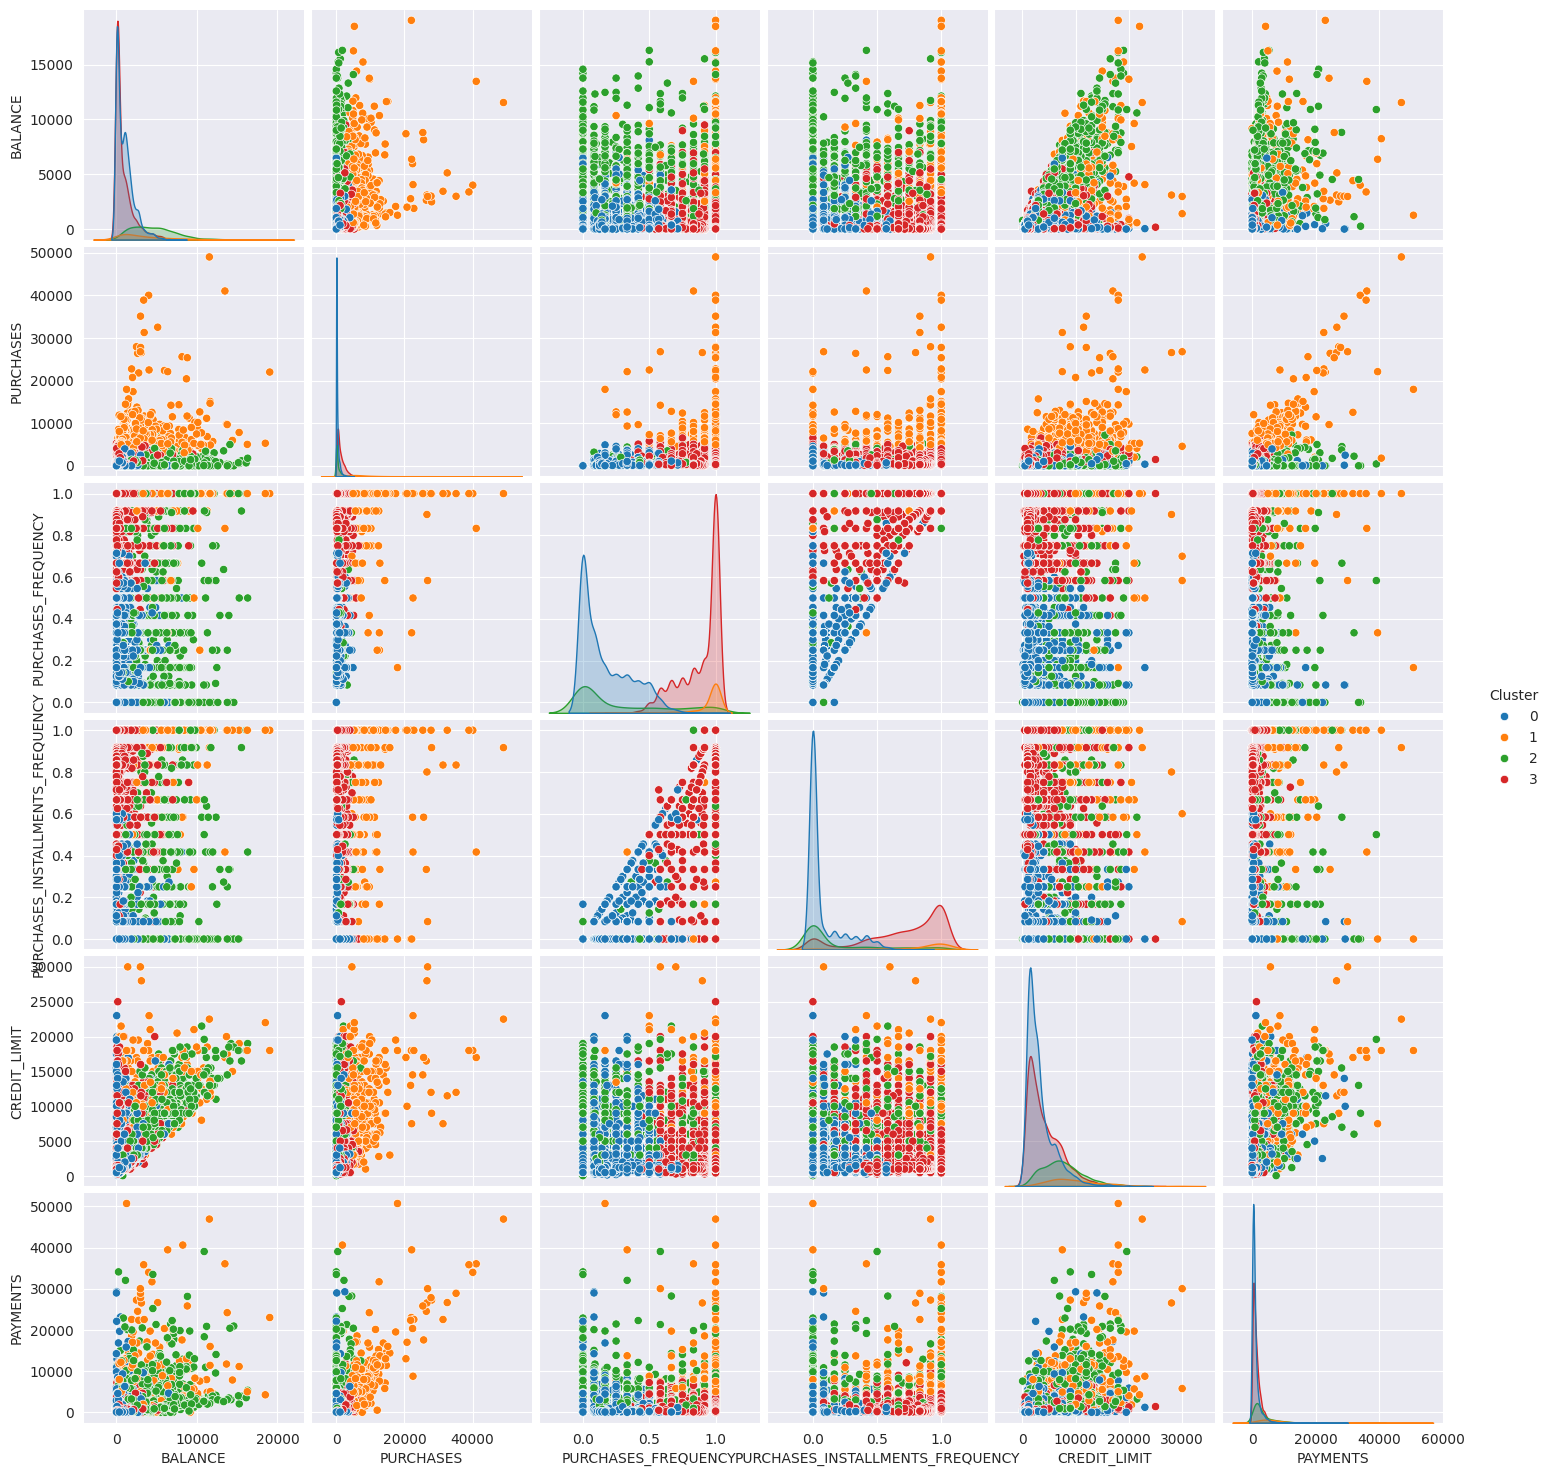

In [42]:
some_cols = ['BALANCE', 'PURCHASES', 'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'Cluster']

sns.pairplot(df_cluster[some_cols], diag_kind='kde', kind='scatter', height=2.5, aspect=1,
             #plot_kws={'alpha':0.5},
             palette='tab10', hue='Cluster')

<Axes: xlabel='Cluster', ylabel='count'>

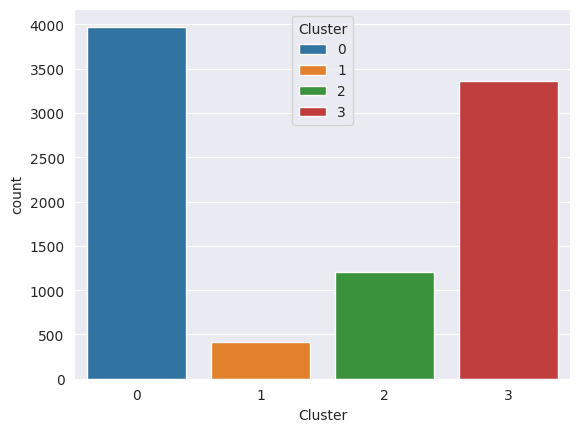

In [51]:
sns.countplot(df_cluster, x='Cluster', palette='tab10', hue='Cluster')

## Training a Cluster Classification Model for Customers

In this section, we will train a classification model to predict the cluster assignments for customers based on the unsupervised clustering results from the previous step. This model will help in categorizing new customers into their respective clusters.

### XGBoost approach

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# as it is an ensemble method based on trees, standardization is not necessary
y = df_cluster['Cluster']
X = df_cluster.drop(axis=1, labels=['Cluster'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train.shape, X_test.shape


((7160, 17), (1790, 17))

So the training will be done with 7160 samples, and the testing on 1790.

In [87]:
xgb = XGBClassifier(max_depth=5, # weak learner trees
                    learning_rate=0.1,
                    n_estimators=250, # n° trees
                    colsample_bytree=0.8, # n° features for each tree
                    subsample=0.8, # n° samples used for each tree
                    eval_metric='mlogloss',
                    n_jobs=-1,
                    reg_lambda=0.1, # L2 reg
                    reg_alpha=0.1, # L1 reg
                    random_state=13)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

### Evaluating the model

In [88]:
y_pred = xgb.predict(X_test)

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       788
           1       0.98      0.91      0.94        97
           2       0.96      0.96      0.96       228
           3       0.97      0.99      0.98       677

    accuracy                           0.98      1790
   macro avg       0.97      0.96      0.97      1790
weighted avg       0.98      0.98      0.98      1790



The classification report highlights the model's overall strong performance with an accuracy of 98%. Classes 0 and 3 have high precision and recall, indicating reliable predictions for these major classes. For the minority classes, Class 1 shows slightly lower recall, suggesting some missed instances, though its precision remains high, reflecting that when it does predict Class 1, it's often correct. Class 2 performs well, with both high precision and recall, demonstrating the model's ability to handle minority classes effectively. The macro and weighted averages support this, showing that despite the imbalance, the model maintains robust predictive performance across all classes.

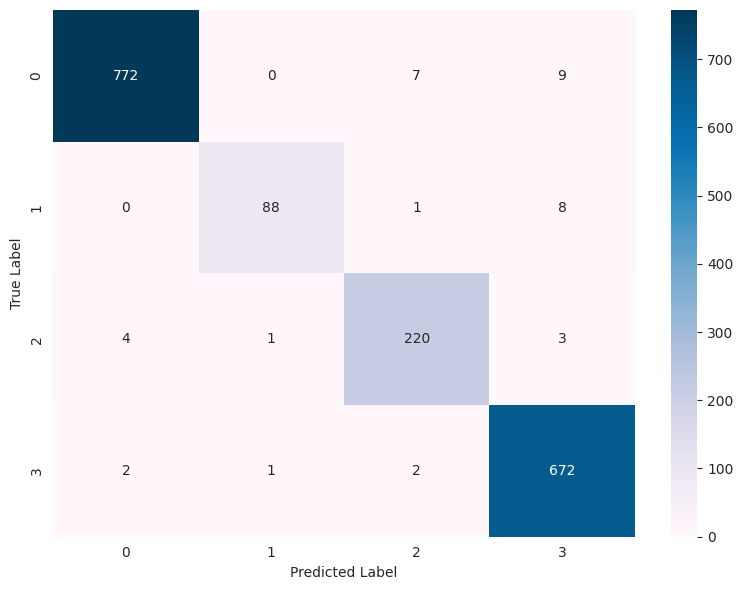

In [94]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

## Conclusion

The unsupervised analysis effectively identified four distinct customer segments, with a notable elbow at four clusters suggesting this as an optimal choice. The silhouette plot revealed that Clusters 0 and 3 exhibit strong clustering quality, while Cluster 1 and 2 show some overlap and mixed silhouette scores. The PCA visualization illustrated that Clusters 0 and 3 are well and densely separated , whereas Clusters 1 and 2 are more dispersed, indicating potential areas for further refinement.

In addition, the XGBoost classification model achieved high accuracy, effectively predicting customer clusters with strong performance across all segments. While there were some missed instances in Class 1, overall, the model supports targeted marketing strategies by reliably classifying customers into their respective segments, offering a solid foundation for further refinement and optimization.